In [ ]:
# pip install pandas numpy shap xgboost azure-ai-openai azure-identity tabulate
# pip install -r requirements.txt

In [27]:
import sys
import os

# sys.path.append("../risk_model")  # Adjust path as needed
# sys.path.append("./risk_model")
# sys.path.append(os.path.dirname(os.getcwd()))

In [28]:
os.path.dirname(os.getcwd()), os.getcwd()

('/Users/leiyu/Projects/coding', '/Users/leiyu/Projects/coding/risk_model')

### 1. Load Libraries & Config

In [65]:
%load_ext autoreload
%autoreload 2

# Import libraries
%load_ext autoreload
%autoreload 2

import shap
from config import (
    AZURE_OPENAI_ENDPOINT,
    AZURE_OPENAI_API_KEY,
    DEPLOYMENT_NAME,
    XGBOOST_PARAMS,
    NUM_SAMPLES,
    FRAUD_RATIO,
    FEATURE_LIBRARY_CSV,
    DUMMY_DATA_CSV,
    TOP_N_FEATURES,
    RISK_SCORE_DECIMALS,
    TEST_SIZE,
    RANDOM_STATE,
    PLOT_SHAP_SUMMARY,
    ENTITY_INDEX_FOR_EXPLANATION
)
from data.data_loader import (
    generate_feature_library_csv,
    # generate_dummy_dataset,
    generate_and_save_aml_data,
    load_dataset
)
from data.feature_library import load_feature_descriptions
from model.trainer import train_xgboost
from model.explainer import compute_shap_values, generate_shap_summary
from narrative.prompt_generator import build_prompt

# from narrative.azure_openai_client import get_azure_openai_client, generate_narrative

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 2. Generate Data

In [54]:
# Generate feature library
generate_feature_library_csv(FEATURE_LIBRARY_CSV)

# Generate dummy dataset and save it
dummy_df = generate_and_save_aml_data(
    num_samples=NUM_SAMPLES,
    fraud_ratio=FRAUD_RATIO
)
dummy_df.to_csv(DUMMY_DATA_CSV, index=False)

# Load dataset
X, y = load_dataset(DUMMY_DATA_CSV)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(y.value_counts())

✅ Feature library CSV saved to data/feature_library.csv
✅ Data generated and saved to data/aml_data.csv
✅ Dataset loaded from data/dummy_aml_data.csv with shape (1000, 31)
X shape: (1000, 30)
y shape: (1000,)
risk_label
0    700
1    300
Name: count, dtype: int64


### 3. Train Model

In [55]:
# Train XGBoost model
model, X_test = train_xgboost(X, y, XGBOOST_PARAMS, TEST_SIZE, RANDOM_STATE)

### 4. Explain One Example

In [56]:
# Choose an entity to explain
entity_index = ENTITY_INDEX_FOR_EXPLANATION
entity_features = X_test.iloc[[entity_index]]

# Predict risk score (probability)
risk_score = model.predict_proba(entity_features)[0, 1]
risk_score

### 5. Compute SHAP Values

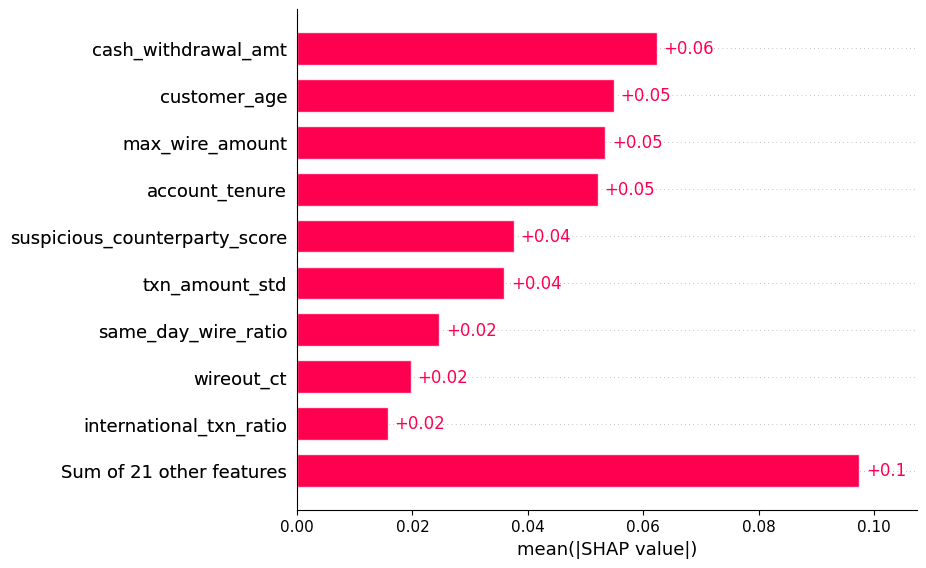

In [58]:
# Get SHAP values for the entity
top_features = compute_shap_values(
    model,
    X,
    entity_features,
    TOP_N_FEATURES,
    plot=PLOT_SHAP_SUMMARY
)

In [59]:
top_features

,Feature,SHAP Value,Abs SHAP Value
14,cash_withdrawal_amt,-0.062393,0.062393
18,customer_age,0.054946,0.054946
3,max_wire_amount,-0.053420,0.053420
19,account_tenure,-0.052096,0.052096
8,suspicious_counterparty_score,-0.037555,0.037555
20,txn_amount_std,-0.035925,0.035925
7,same_day_wire_ratio,-0.024671,0.024671
1,wireout_ct,-0.019698,0.019698
22,international_txn_ratio,-0.015757,0.015757
13,cash_deposit_amt,-0.015359,0.015359


/Users/leiyu/Projects/coding/risk_model/model/explainer.py:68: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


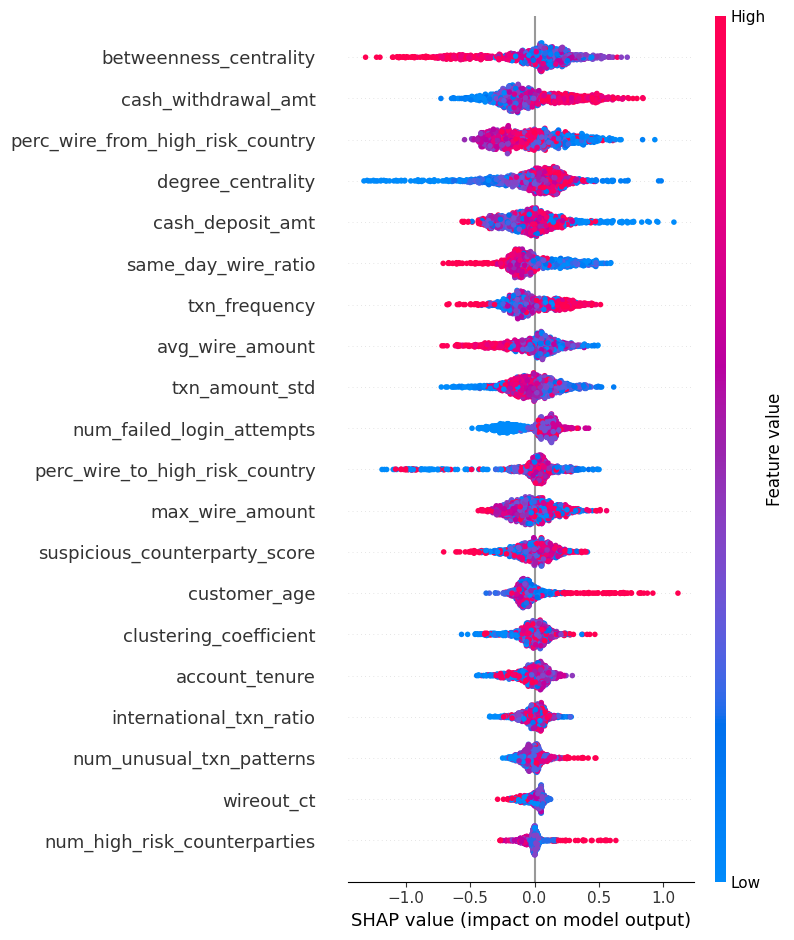

In [66]:
generate_shap_summary(model, X, plot_summary=True)

### 6. Load Feature Descriptions

In [67]:
feature_descriptions = load_feature_descriptions(feature_names=X.columns)

### 7. Build Prompt

In [68]:
prompt = build_prompt(risk_score, top_features, feature_descriptions)
print("=== Prompt to LLM ===")
print(prompt)

=== Prompt to LLM ===
You are a risk model explanation assistant. Given a risk score and a list of features with their descriptions and contributions, generate a clear, concise narrative explaining the risk score.

Risk Score: 9.06%

Top Features and Contributions:
- cash_withdrawal_amt (cash_withdrawal_amt): This feature decreased the risk score, contributing 16.8% of the total impact.
- customer_age (customer_age): This feature increased the risk score, contributing 14.8% of the total impact.
- max_wire_amount (max_wire_amount): This feature decreased the risk score, contributing 14.4% of the total impact.
- account_tenure (account_tenure): This feature decreased the risk score, contributing 14.0% of the total impact.
- suspicious_counterparty_score (suspicious_counterparty_score): This feature decreased the risk score, contributing 10.1% of the total impact.
- txn_amount_std (txn_amount_std): This feature decreased the risk score, contributing 9.7% of the total impact.
- same_day_wi

### 8. Call Azure OpenAI

In [ ]:
client = get_azure_openai_client(AZURE_OPENAI_ENDPOINT)
narrative = generate_narrative(client, DEPLOYMENT_NAME, prompt)
print("=== LLM Narrative ===")
print(narrative)

### 9. Summarize

In [ ]:
summary_table = pd.DataFrame({
    "Entity Index": [entity_index],
    "Predicted Risk Score (%)": [round(risk_score * 100, 2)],
    "Top Features": [", ".join(top_features['Feature'])],
    "Narrative": [narrative],
    "Evaluation Score": ["N/A (manual review recommended)"]
})

print(tabulate(summary_table, headers="keys", tablefmt="fancy_grid", showindex=False))